### Extract core financial concept for data model construction 

#### 1.1 Extract all qa-pairs

In [2]:
import pandas as pd
# Load the dataset
file_path = "/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/merged_dataset.json" 

# Load JSONL file (each line is a JSON object)
df = pd.read_json(file_path, lines=True)

# Preview the dataset
print("Columns in dataset:", df.columns)
df.head()

Columns in dataset: Index(['ID', 'question', 'answer', 'context', 'gold_context', 'operation',
       'source'],
      dtype='object')


,ID,question,answer,context,gold_context,operation,source
0,ADI/2009/page_49.pdf,what is the the interest expense in 2009?,380,['interest rate to a variable interest rate ba...,{'text_1': 'if libor changes by 100 basis poin...,"divide(100, 100), divide(3.8, #0)",FinQA
1,AAL/2018/page_13.pdf,what was the total operating expenses in 2018 ...,41932,['the following table shows annual aircraft fu...,{'table_1': 'year the 2018 of gallons is 4447 ...,"divide(9896, 23.6%)",FinQA
2,INTC/2013/page_71.pdf,what percentage of total cash and investments ...,53%,['the fair value of our grants receivable is d...,{'table_1': '( in millions ) the available-for...,"divide(14001, 26302)",FinQA
3,ETR/2008/page_313.pdf,what is the growth rate in net revenue in 2008?,-3.2%,"[""entergy louisiana , llc management's financi...",{'table_1': 'the 2007 net revenue of amount ( ...,"subtract(959.2, 991.1), divide(#0, 991.1)",FinQA
4,C/2010/page_272.pdf,what was the growth rate of the loans held-for...,56.25%,"['the significant changes from december 31 , 2...",{'table_1': 'in billions of dollars the decemb...,"divide(2.5, 1.6), divide(#0, 1.6)",FinQA


In [3]:
# Filter for question-answer pairs
qa_df = df[['question', 'answer']].copy()
qa_df.dropna(subset=['question', 'answer'], inplace=True)

# Preview the data
print(f"Loaded {len(qa_df)} QA pairs")
qa_df.head()

Loaded 17201 QA pairs


,question,answer
0,what is the the interest expense in 2009?,380
1,what was the total operating expenses in 2018 ...,41932
2,what percentage of total cash and investments ...,53%
3,what is the growth rate in net revenue in 2008?,-3.2%
4,what was the growth rate of the loans held-for...,56.25%


#### 1.2. Create a list with all relevant entities and relationships

Create a whitelist for relevant metrics: 

In [22]:
import re, requests, pandas as pd
from lxml import etree

# -----------------------------------------------------------------
# ❶  Choose ONE input:  URL  or  local file you downloaded
# -----------------------------------------------------------------
XSD_SOURCE = "file"           # "url"  or  "file"

if XSD_SOURCE == "url":
    xml_bytes = requests.get(
        "https://xbrl.fasb.org/us-gaap/2023/elts/us-gaap-2023.xsd",
        headers={"User-Agent": "metric-extractor/1.0"}
    ).content
else:   # local file path
    with open("/Users/christel/Desktop/us-gaap-2023.xsd.xml", "rb") as f:
        xml_bytes = f.read()

# -----------------------------------------------------------------
# ❷  Parse XML and collect all link:loc @xlink:href values
# -----------------------------------------------------------------
ns = {
    "link":  "http://www.xbrl.org/2003/linkbase",
    "xlink": "http://www.w3.org/1999/xlink",
}
root   = etree.fromstring(xml_bytes)
hrefs  = root.xpath("//link:loc/@xlink:href", namespaces=ns)

# -----------------------------------------------------------------
# ❸  Pull out names that start with  us-gaap_  (strip the leading #)
# -----------------------------------------------------------------
raw_tags = []
for h in hrefs:
    m = re.search(r"us-gaap_[A-Za-z0-9]+", h)   # grabs 'us-gaap_Revenues'
    if m:
        raw_tags.append(m.group(0).replace("us-gaap_", ""))

# -----------------------------------------------------------------
# ❹  OPTIONAL: filter out obvious non‑metrics
#     (Abstract, TextBlock, Member, Domain, etc.)
# -----------------------------------------------------------------
ignore_suffixes = ("Abstract", "TextBlock", "Member", "Domain", "Axis")
tags = [
    t for t in raw_tags
    if not any(t.endswith(suf) for suf in ignore_suffixes)
]

# -----------------------------------------------------------------
# ❺  Convert CamelCase → plain text, deduplicate, save
# -----------------------------------------------------------------
def camel_to_words(tag):
    tag = re.sub(r"([a-z0-9])([A-Z])", r"\1 \2", tag)
    tag = re.sub(r"([A-Z]+)([A-Z][a-z])", r"\1 \2", tag)
    return tag.lower().strip()

whitelist = sorted({camel_to_words(t) for t in tags})

pd.DataFrame(whitelist, columns=["metric"]).to_csv(
    "us_gaap_metric_whitelist.csv", index=False
)

print(f"✅  Extracted {len(whitelist)} clean GAAP metrics → us_gaap_metric_whitelist.csv")


✅  Extracted 100 clean GAAP metrics → us_gaap_metric_whitelist.csv


In [23]:
import pandas as pd, re, itertools, collections

QA_FILE = "/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/merged_dataset.json"               # your combined dataset
df = pd.read_json(QA_FILE, lines=True)     # assumes question+answer columns

# preprocess to lower‑case text and join Q+A
texts = (df["question"] + " " + df["answer"]).str.lower().tolist()

# finance cue words to anchor the regex
CUES = r"(revenue|income|profit|margin|ratio|eps|ebit[da]?|cash flow|expenses?)"

# collect 1‑ to 4‑word n‑grams containing a cue
candidate_counter = collections.Counter()

for txt in texts:
    words = re.findall(r"[a-z]+", txt)
    for n in range(1, 5):
        for gram in zip(*(words[i:] for i in range(n))):
            phrase = " ".join(gram)
            if re.search(CUES, phrase):
                candidate_counter[phrase] += 1

# keep those that appear ≥ 3 times and aren’t already in GAAP list
gaap = set(pd.read_csv("us_gaap_metric_whitelist.csv")["metric"])
candidates = [p for p,c in candidate_counter.items() if c >= 3 and p not in gaap]

print(f"Found {len(candidates)} candidate phrases")
pd.Series(candidates).to_csv("metric_candidates_raw.csv", index=False)


Found 14886 candidate phrases


### NEW: Create Context File

#### Remove duplicates from context
avoids embedding duplicates and reduces unnecessary costs.

In [ ]:
# count unique values in context
import json
# Load JSON Lines (jsonl) format
with open("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/merged_dataset.json", "r") as f:
    data = [json.loads(line) for line in f if line.strip()]

# Count unique values in context
unique_contexts = set()
for item in data:
    unique_contexts.update(item.get("context", []))

print(f"Total unique context entries: {len(unique_contexts)}")

In [ ]:
# Extract all context entries from all questions
all_contexts = []
for item in data:
    all_contexts.extend(item.get("context", []))

total_before = len(all_contexts)

# Deduplicate globally across dataset
seen = set()
unique_contexts = []
for text in all_contexts:
    if text not in seen:
        unique_contexts.append(text)
        seen.add(text)

total_after = len(unique_contexts)

# Log result
print(f"\nTotal context entries BEFORE deduplication: {total_before}")
print(f"Total context entries AFTER deduplication: {total_after}")
print(f"Removed {total_before - total_after} duplicate entries\n")



Total context entries BEFORE deduplication: 46480219
Total context entries AFTER deduplication: 5892
Removed 46474327 duplicate entries



#### Clean the context file 

In [35]:
import json
from collections import Counter

with open("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/unique_contexts.json") as f:
    contexts = json.load(f)

# Calculate lengths of each context string
lengths = [len(c.strip()) for c in contexts]

# Bucketize the lengths for histogram
buckets = [f"{(l//10)*10}-{(l//10)*10+9}" for l in lengths]
length_dist = Counter(buckets)

# Print top length buckets
print("\n📊 Length distribution (grouped by 10s):")
for bucket, count in sorted(length_dist.items()):
    print(f"{bucket} chars: {count} entries")

# See how many are very short (likely garbage)
short_count = sum(1 for l in lengths if l < 30)
print(f"\n❗ Entries shorter than 30 characters: {short_count}/{len(contexts)}")



📊 Length distribution (grouped by 10s):
0-9 chars: 68 entries
10-19 chars: 1 entries
100-109 chars: 2 entries
1000-1009 chars: 17 entries
10020-10029 chars: 1 entries
10040-10049 chars: 1 entries
10050-10059 chars: 1 entries
1010-1019 chars: 19 entries
10100-10109 chars: 1 entries
10110-10119 chars: 1 entries
10150-10159 chars: 1 entries
10170-10179 chars: 1 entries
10190-10199 chars: 1 entries
1020-1029 chars: 25 entries
10200-10209 chars: 1 entries
10220-10229 chars: 1 entries
10230-10239 chars: 1 entries
10280-10289 chars: 1 entries
10290-10299 chars: 1 entries
1030-1039 chars: 14 entries
10310-10319 chars: 1 entries
10320-10329 chars: 1 entries
10340-10349 chars: 2 entries
10350-10359 chars: 1 entries
10360-10369 chars: 1 entries
10390-10399 chars: 1 entries
1040-1049 chars: 21 entries
10410-10419 chars: 1 entries
10420-10429 chars: 1 entries
10430-10439 chars: 1 entries
10450-10459 chars: 1 entries
1050-1059 chars: 22 entries
10510-10519 chars: 2 entries
10520-10529 chars: 1 entr

In [36]:
short_contexts = [c for c in contexts if len(c.strip()) < 20]

print(f"🔎 Found {len(short_contexts)} short context entries (< 20 chars):\n")
for i, entry in enumerate(short_contexts, 1):
    print(f"{i:>2}: '{entry}'")

🔎 Found 69 short context entries (< 20 chars):

 1: '['
 2: '''
 3: 'i'
 4: 'n'
 5: 't'
 6: 'e'
 7: 'r'
 8: 's'
 9: ' '
10: 'a'
11: 'o'
12: 'v'
13: 'b'
14: 'l'
15: 'd'
16: 'h'
17: '-'
18: 'm'
19: 'p'
20: 'u'
21: '2'
22: '.'
23: '0'
24: '5'
25: '%'
26: '('
27: ')'
28: '3'
29: '4'
30: 'f'
31: 'c'
32: '1'
33: ','
34: '9'
35: 'g'
36: 'y'
37: 'x'
38: 'w'
39: '$'
40: '8'
41: 'k'
42: 'j'
43: ':'
44: ']'
45: '
'
46: '	'
47: '6'
48: '7'
49: 'q'
50: 'z'
51: '"'
52: ';'
53: '/'
54: '&'
55: '*'
56: '|'
57: '+'
58: '_'
59: '<'
60: '>'
61: '\'
62: '='
63: '!'
64: '@'
65: '{'
66: '}'
67: '#'
68: 'None.'
69: 'Not applicable.'


In [37]:
contexts_cleaned = [c for c in contexts if len(c.strip()) >= 20]

with open("unique_contexts_filtered.json", "w") as f:
    json.dump(contexts_cleaned, f, indent=2)

print(f"\nCleaned contexts saved ({len(contexts_cleaned)} entries)")



Cleaned contexts saved (5823 entries)


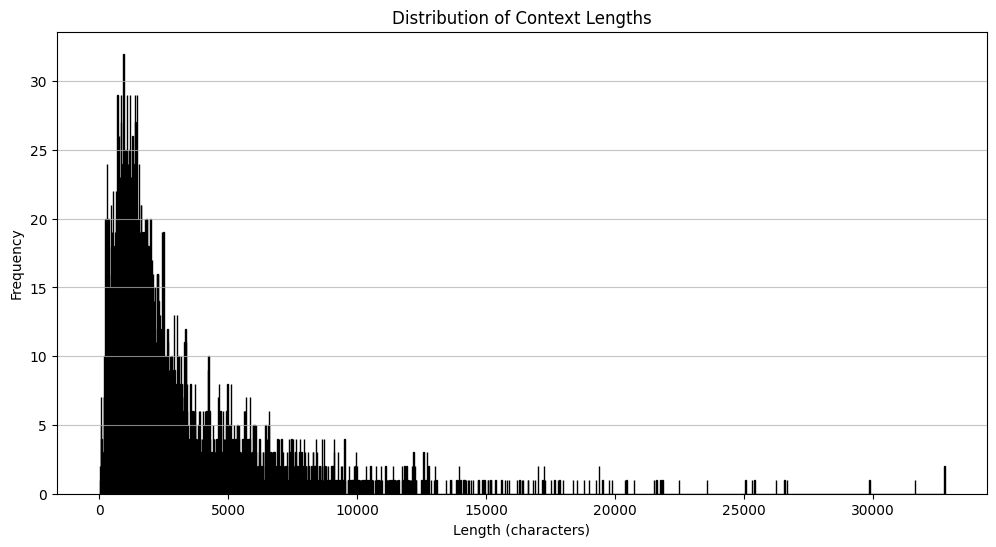

In [38]:
# create a graph that shows the distribution of context lengths
import matplotlib.pyplot as plt


lengths = [len(c.strip()) for c in contexts_cleaned]
plt.figure(figsize=(12, 6))
plt.hist(lengths, bins=range(0, max(lengths) + 10, 10), color='skyblue', edgecolor='black')
plt.title('Distribution of Context Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

#### Calculate the number of tokens 

In [40]:
import json
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter
import tiktoken

# === Config ===
DOCS_PATH = "/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/unique_contexts_filtered.json"
CHUNK_SIZE = 1500
CHUNK_OVERLAP = 200
EMBEDDING_MODEL = "text-embedding-ada-002"
PRICE_PER_MILLION = 0.10  # USD

# === Load JSON ===
with open(DOCS_PATH) as f:
    data = json.load(f)  # data is now a list of strings

# === Tokenizer ===
enc = tiktoken.encoding_for_model(EMBEDDING_MODEL)

def count_tokens(text):
    return len(enc.encode(text))

# === Prepare Docs ===
docs = []
for idx, context in enumerate(data):
    if isinstance(context, str) and context.strip():
        docs.append(Document(page_content=context, metadata={"row_index": idx}))

# === Chunker ===
text_splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP
)

# === Process & Count ===
total_tokens = 0
total_chunks = 0

for doc in docs:
    chunks = text_splitter.split_documents([doc])
    total_chunks += len(chunks)

    for chunk in chunks:
        token_count = count_tokens(chunk.page_content)
        total_tokens += token_count

# === Estimate Cost ===
estimated_cost = (total_tokens / 1_000_000) * PRICE_PER_MILLION

print(f"🔹 Total Chunks: {total_chunks}")
print(f"🔹 Total Tokens: {total_tokens:,}")
print(f"💰 Estimated Embedding Cost: ${estimated_cost:.2f}")


Created a chunk of size 1568, which is longer than the specified 1500
Created a chunk of size 1591, which is longer than the specified 1500
Created a chunk of size 1997, which is longer than the specified 1500
Created a chunk of size 1754, which is longer than the specified 1500
Created a chunk of size 4701, which is longer than the specified 1500
Created a chunk of size 3737, which is longer than the specified 1500
Created a chunk of size 7371, which is longer than the specified 1500
Created a chunk of size 1546, which is longer than the specified 1500
Created a chunk of size 4624, which is longer than the specified 1500
Created a chunk of size 1739, which is longer than the specified 1500
Created a chunk of size 1747, which is longer than the specified 1500
Created a chunk of size 2219, which is longer than the specified 1500
Created a chunk of size 2879, which is longer than the specified 1500
Created a chunk of size 4490, which is longer than the specified 1500
Created a chunk of s

🔹 Total Chunks: 9997
🔹 Total Tokens: 3,624,780
💰 Estimated Embedding Cost: $0.36


#### Chunk, Embedd and Save the Context

In [9]:
import os
import json
from dotenv import load_dotenv
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings

In [8]:
# Load .env variables
load_dotenv()

# Configuration
DOCS_PATH = "/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/unique_contexts_filtered.json"  
CHUNK_SIZE = 1500
CHUNK_OVERLAP = 200

# Load dataset
with open(DOCS_PATH) as f:
    raw_data = json.load(f)

# Create LangChain Documents
docs = [
    Document(page_content=entry.strip(), metadata={"row_index": idx})
    for idx, entry in enumerate(raw_data)
    if isinstance(entry, str) and entry.strip()
]

# Initialize splitter
splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP
)

# Split into chunks
all_chunks = []
for doc in docs:
    row_index = doc.metadata["row_index"]
    chunks = splitter.split_documents([doc])
    for local_idx, chunk in enumerate(chunks):
        chunk_id = f"row_{row_index}_chunk_{local_idx}"
        all_chunks.append({
            "chunk_id": chunk_id,
            "row_index": row_index,
            "text": chunk.page_content
        })

print(f"Total chunks created: {len(all_chunks)}")

Created a chunk of size 1568, which is longer than the specified 1500
Created a chunk of size 1591, which is longer than the specified 1500
Created a chunk of size 1997, which is longer than the specified 1500
Created a chunk of size 1754, which is longer than the specified 1500
Created a chunk of size 4701, which is longer than the specified 1500
Created a chunk of size 3737, which is longer than the specified 1500
Created a chunk of size 7371, which is longer than the specified 1500
Created a chunk of size 1546, which is longer than the specified 1500
Created a chunk of size 4624, which is longer than the specified 1500
Created a chunk of size 1739, which is longer than the specified 1500
Created a chunk of size 1747, which is longer than the specified 1500
Created a chunk of size 2219, which is longer than the specified 1500
Created a chunk of size 2879, which is longer than the specified 1500
Created a chunk of size 4490, which is longer than the specified 1500
Created a chunk of s

Total chunks created: 9997


OpenAI’s embeddings are trained with the same internal tokenizer, so retrieval + generation are often well-aligned

In [10]:
# Initialize embedding provider
embedding_model = OpenAIEmbeddings(
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    model="text-embedding-ada-002"
)

# Embed and store
embedded_chunks = []
for chunk in all_chunks:
    try:
        embedding = embedding_model.embed_query(chunk["text"])
        chunk["embedding"] = embedding
        embedded_chunks.append(chunk)
    except Exception as e:
        print(f"Failed embedding chunk {chunk['chunk_id']}: {e}")

print(f"Successfully embedded {len(embedded_chunks)} chunks.")


Successfully embedded 9997 chunks.


In [11]:
with open("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/embedded_chunks.json", "w") as f:
    json.dump(embedded_chunks, f)

print("Chunks saved to /Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/embedded_chunks.json")

Chunks saved to /Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/embedded_chunks.json


## Test Retriever 

### Create a Validation Dataset

In [4]:
import json
import pandas as pd

# Load the unique contexts (first 100)
with open("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/unique_contexts_filtered.json", "r") as f:
    unique_contexts = json.load(f)

# Get first 281 contexts
already_implemented_contexts = unique_contexts[:281]
print(f"Selected first {len(already_implemented_contexts)} contexts")

# Load validation dataset (JSON array format, not JSONL)
df_val = pd.read_json("/Users/christel/Desktop/Thesis/thesis_repo/data/data_processed/Train_Val_Test/df_val.json")
print(f"Loaded validation set with {len(df_val)} rows")

# Create a set of the first 281 contexts for faster lookup
context_set = set(already_implemented_contexts)

# Find questions that have context matching our first 281 contexts
matching_questions = []
matching_indices = []

for idx, row in df_val.iterrows():
    # Check if any context in this row matches our first 281 contexts
    row_contexts = row.get('context', [])
    if isinstance(row_contexts, str):
        row_contexts = [row_contexts]

    # Check if any context from this row is in our first 281
    if any(ctx in context_set for ctx in row_contexts if isinstance(ctx, str)):
        matching_questions.append(row['question'])
        matching_indices.append(idx)

print(f"\nFound {len(matching_questions)} questions related to the first 281 contexts")
print(f"Question indices: {matching_indices[:10]}..." if len(matching_indices) > 10 else f"Question indices: {matching_indices}")

# Display first few questions as examples
print(f"\nFirst 3 matching questions:")
for i, question in enumerate(matching_questions[:3]):
    print(f"{i+1}. {question}")

Selected first 281 contexts
Loaded validation set with 1720 rows

Found 23 questions related to the first 281 contexts
Question indices: [9, 25, 61, 81, 211, 298, 331, 377, 436, 522]...

First 3 matching questions:
1. 2024 total opex: Nordson Corp (NDSN) cost-of-sales + S&A
2. Impact of community mktg on LULU's CAC & loyalty metrics.
3. Competitiveness of Synopsys in risk mitigation affects financial outcomes, ticker at last.


In [6]:
# Create the final list of questions for your graph retriever
questions_for_retriever = matching_questions.copy()

print(f"Created list of {len(questions_for_retriever)} questions for graph retriever")
print("\nYou can now use 'questions_for_retriever' as input to your graph retriever")

# Optional: Save the questions to a file for later use
with open("validation_questions_first_100_contexts.json", "w") as f:
    json.dump(questions_for_retriever, f, indent=2)

# Optional: Create a DataFrame with questions and their indices for analysis
results_df = pd.DataFrame({
    'question_index': matching_indices,
    'question': matching_questions
})

print(f"\nSample of questions_for_retriever:")
for i, q in enumerate(questions_for_retriever[:5]):
    print(f"Question {i+1}: {q[:281]}..." if len(q) > 281 else f"Question {i+1}: {q}")

# Summary statistics
print(f"\n📊 Summary:")
print(f"  • Total unique contexts: {len(unique_contexts)}")
print(f"  • First 281 contexts selected: {len(already_implemented_contexts)}")
print(f"  • Total validation questions: {len(df_val)}")
print(f"  • Questions matching first 281 contexts: {len(questions_for_retriever)}")
print(f"  • Match percentage: {len(questions_for_retriever)/len(df_val)*100:.1f}%")

Created list of 23 questions for graph retriever

You can now use 'questions_for_retriever' as input to your graph retriever

Sample of questions_for_retriever:
Question 1: 2024 total opex: Nordson Corp (NDSN) cost-of-sales + S&A
Question 2: Impact of community mktg on LULU's CAC & loyalty metrics.
Question 3: Competitiveness of Synopsys in risk mitigation affects financial outcomes, ticker at last.
Question 4: NetApp's buyback and div payout affect liquidity.
Question 5: NVIDIA's cap allocation efficiency, liability mitigation, and impact of external cybersecurity consultations.

📊 Summary:
  • Total unique contexts: 5823
  • First 281 contexts selected: 281
  • Total validation questions: 1720
  • Questions matching first 281 contexts: 23
  • Match percentage: 1.3%
